In [1]:
import joblib
import numpy as np
import pandas as pd
import gc
import time
import os
import sys
from contextlib import contextmanager
from lightgbm import LGBMClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV 
# from optbinning import OptimalBinning
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import random
import eli5
import matplotlib.gridspec as gridspec
from IPython.display import display
from eli5.permutation_importance import get_score_importances
from eli5.sklearn import PermutationImportance
import itertools
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(1)

In [4]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [5]:
def train_model(train,test,params,stratified,num_folds,drop_features,seed_num):
    
    # start log 
    print('-'*50)
    print('>> seed_num:',seed_num)   
    print('>> drop_features:',len(drop_features))
    
    seed_everything(1)
    
    # Divide in training/validation and test data
    train_df = train.copy()
    test_df = test.copy()

    # label encoding 
    encoder = LabelEncoder()
    categorical_features = [i for i in train_df.select_dtypes(include=['object','category']).columns.tolist() if i not in ['ID']]
    categorical_features = [i for i in categorical_features if i in train_df.columns.tolist()]
    for each in categorical_features:
        train_df[each] = encoder.fit_transform(train_df[each])
        test_df[each] = encoder.fit_transform(test_df[each])

    # set training options
    stratified = stratified
    num_folds = num_folds

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1)

    # Create arrays and dataframes to store results
    oof_preds_lgb = np.zeros(train_df.shape[0])
    sub_preds_lgb = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['Y_LABEL','ID','SAMPLE_TRANSFER_DAY']+drop_features]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['Y_LABEL'])):
        
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['Y_LABEL'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['Y_LABEL'].iloc[valid_idx]

        categorical_feature = []        
        lgb_train = lgb.Dataset(data=train_x, label=train_y, categorical_feature=categorical_feature)
        lgb_valid = lgb.Dataset(data=valid_x, label=valid_y, reference=lgb_train, categorical_feature=categorical_feature)
        
        with warnings.catch_warnings():
            
            warnings.filterwarnings('ignore')  
            
            clf = lgb.train(

                params,                
                train_set = lgb_train,
                valid_sets = [lgb_train,lgb_valid],
                verbose_eval = -1,
                num_boost_round = 10000,
                categorical_feature = categorical_feature
            )

        oof_preds_lgb[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration)
        sub_preds_lgb += clf.predict(test_df[feats], num_iteration=clf.best_iteration) / folds.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance_gain"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["importance_split"] = clf.feature_importance(importance_type='split')
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds_lgb[valid_idx])))

    print('Full AUC score %.6f' % roc_auc_score(train_df['Y_LABEL'], oof_preds_lgb))

    # Write submission file and plot feature importance
    test_df['Y_LABEL_lgb'] = sub_preds_lgb

    # vi
    # print('-'*50)
    display(feature_importance_df.groupby(['feature'])['importance_gain'].sum().sort_values(ascending=False).head(30))
    # print('-'*50)
    # display_importances(feature_importance_df)
    
    # train auc
    oof_auc = roc_auc_score(train_df['Y_LABEL'], oof_preds_lgb)

    
    if oof_auc>=0.703:

        # find the best thred for f1-score
        f1_score_df = pd.DataFrame()
        for thred in [i/10000 for i in range(0,10000,1) if (i/10000>0.1) & (i/10000<0.3)]:

            a1 = pd.DataFrame()
            f1 = f1_score(train_df['Y_LABEL'], np.where(oof_preds_lgb>=thred,1,0), average='macro')
            a1['f1'] = [f1]
            a1['thred'] = [thred]
            f1_score_df = pd.concat([f1_score_df, a1], axis=0)

        thred = f1_score_df.loc[f1_score_df['f1']==f1_score_df['f1'].max(),'thred'].tolist()[0]
        print('thred:',thred)
        print('ncol',len(feats))

        # train f1
        print('auc:',oof_auc)
        oof_f1 = f1_score(train_df['Y_LABEL'], np.where(oof_preds_lgb>thred,1,0), average='macro')
        print('f1:',oof_f1)
        a1 = train_df['Y_LABEL'].value_counts()/len(train_df)
        print('Target ratio(real):',(a1[1]))

        # test err
        test_df['TARGET'] = np.where(test_df['Y_LABEL_lgb']>thred,1,0)
        a1 = test_df['TARGET'].value_counts()/len(test_df)
        print('Target ratio(pred):',(a1[1]))
        target_sum = test_df['TARGET'].sum()
        print('Target sum:',target_sum)
        
        if (target_sum>=510) & (target_sum<590):

            # save 
            train_df['Y_LABEL_lgb'] = oof_preds_lgb
            a1 = train_df[['ID','YEAR','COMPONENT_ARBITRARY','Y_LABEL_lgb','Y_LABEL']].copy()
            a1.to_csv('train_pred_'+str(seed_num)+'_'+str(np.round(oof_f1,10))+'.csv', index= False)    
            a1 = test_df[['ID','YEAR','COMPONENT_ARBITRARY','Y_LABEL_lgb']].copy()
            a1.to_csv('test_pred_'+str(seed_num)+'_'+str(np.round(oof_f1,10))+'.csv', index= False)

            # submit
            a1 = test_df[['ID', 'TARGET']].copy()
            a1 = a1.rename(columns={'TARGET':'Y_LABEL'})
            submission_file_name = 'sample_submission_lgb_'+str(np.round(oof_f1,4))+'.csv'
            a1.to_csv(submission_file_name, index= False)

In [6]:
def permutation_lgb_vi(train, params, drop_features):
    
    params = {'application':'binary', 'metric':'auc'}
    params['learning_rate'] = max(min(best_params['learning_rate'], 1), 0)
    params["num_leaves"] = int(round(best_params['num_leaves']))
    params['colsample_bytree'] = max(min(best_params['colsample_bytree'], 1), 0)
    params['subsample'] = max(min(best_params['subsample'], 1), 0)
    params['max_depth'] = int(round(best_params['max_depth']))        
    params['reg_alpha'] = best_params['reg_alpha']
    params['reg_lambda'] = best_params['reg_lambda']        
    params['min_split_gain'] = best_params['min_split_gain']
    params['min_child_weight'] = best_params['min_child_weight']
    params['min_child_samples'] = int(round(best_params['min_child_samples']))

    train_df = train.copy()

    # label encoding 
    encoder = LabelEncoder()
    categorical_features = [i for i in train_df.select_dtypes(include=['object','category']).columns.tolist() if i not in ['ID']]
    categorical_features = [i for i in categorical_features if i in train_df.columns.tolist()]
    for each in categorical_features:
        train_df[each] = encoder.fit_transform(train_df[each])

    stratified = True

    if stratified:
        folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1)
    else:
        folds = KFold(n_splits= 5, shuffle=True, random_state=1)

    FEATURES = [f for f in train_df.columns if f not in ['Y_LABEL','ID','SAMPLE_TRANSFER_DAY']+drop_features]
    TARGET_COL = 'Y_LABEL'
    feature_importance_df = pd.DataFrame()
    for fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, train_df[TARGET_COL])):
        clf = LGBMClassifier(
            **params, 
            random_state=1, 
            n_jobs = -1,
            silent=True,
            n_estimators=10000
        )

        with warnings.catch_warnings():

            warnings.filterwarnings('ignore')

            clf.fit(
                train_df.loc[train_idx, FEATURES], 
                train_df.loc[train_idx, TARGET_COL], 
                eval_metric="auc", 
                verbose=False,
                early_stopping_rounds=500,
                eval_set=[(train_df.loc[valid_idx, FEATURES],train_df.loc[valid_idx, TARGET_COL])]
            )    
            
        # scoring = 'f1'
        perm = PermutationImportance(clf, n_iter=60, scoring='roc_auc',random_state=1).fit(train_df.loc[valid_idx, FEATURES],train_df.loc[valid_idx, TARGET_COL])
        fold_importance_df = eli5.explain_weights_df(perm, top = len(FEATURES), feature_names = FEATURES)
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print(f"Permutation importance for fold {fold}")
    
    return feature_importance_df

In [7]:
# read data
train = pd.read_csv('/kaggle/input/dacon001/open/train.csv')
test = pd.read_csv('/kaggle/input/dacon001/open/test.csv')
sample_submission = pd.read_csv('/kaggle/input/dacon001/open/sample_submission.csv')
original_columns = test.columns.tolist()

In [8]:
# test데이터셋에 있는 변수만 선택 
train = train[test.columns.to_list()+['Y_LABEL','SAMPLE_TRANSFER_DAY']].copy()

In [9]:
cat_features  = ['YEAR','COMPONENT_ARBITRARY']
num_features13 = ['AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI',  'TI', 'V', 'V40', 'ZN']
num_features3 = ['ANONYMOUS_1', 'ANONYMOUS_2','PQINDEX'] 
all_num_features = num_features13 + num_features3

변수중요도높은변수 = ['V40','FE','ZN','CU'] # 변수중요도 높은 원소들 
타겟과음의상관관계 = ['ZN','H2O'] # 타겟과 마이너스 상관관계 

제로비율이높은변수 = ['AG','CO','H2O','TI','V']+['NI']
제로비율이절반변수 = ['CR','MN','MO']
제로비율이낮은변수 = ['ANONYMOUS_1','ANONYMOUS_2','PQINDEX ','V40','FE','ZN','CU']

In [10]:
# 타겟과 음의 상관관꼐 변수들
train['ZN'] = (-train['ZN'])
train['H2O'] = (-train['H2O'])
test['ZN'] = (-test['ZN'])
test['H2O'] = (-test['H2O'])

In [11]:
"""
normalization
""" 

for var in all_num_features:
    
    a1_min = train[var].min()
    a1_max = train[var].max()
    train[var] = (train[var] - a1_min) / (a1_max-a1_min)
    test[var] = (test[var] - a1_min) / (a1_max-a1_min)

In [12]:
%%time

"""
make psudo id
"""

group_features = all_num_features
group_features = list(set(group_features))

for c1, c2 in [i for i in itertools.combinations(group_features,2)]:
    new_c = f'{c1}_{c2}_mul'
    train[new_c] = train[[c1,c2]].apply(lambda x: x[c1]*x[c2],axis=1)
    test[new_c] = test[[c1,c2]].apply(lambda x: x[c1]*x[c2],axis=1)    
    
for c1, c2 in [i for i in itertools.combinations(group_features,2)]:
    new_c = f'{c1}_{c2}_minus'
    train[new_c] = train[[c1,c2]].apply(lambda x: x[c1]-x[c2],axis=1)
    test[new_c] = test[[c1,c2]].apply(lambda x: x[c1]-x[c2],axis=1)
    
for c1, c2 in [i for i in itertools.combinations(group_features,2)]:
    new_c = f'{c1}_{c2}_plus'
    train[new_c] = train[[c1,c2]].apply(lambda x: x[c1]+x[c2],axis=1)
    test[new_c] = test[[c1,c2]].apply(lambda x: x[c1]+x[c2],axis=1)
    
for c1, c2 in [i for i in itertools.combinations(group_features,2)]:
    new_c = f'{c1}_{c2}_div'
    train[new_c] = train[[c1,c2]].apply(lambda x: x[c1]/(x[c2]+0.00001),axis=1)
    test[new_c] = test[[c1,c2]].apply(lambda x: x[c1]/(x[c2]+0.00001),axis=1)
    
for c1, c2 in [i for i in itertools.combinations(group_features,2)]:
    new_c = f'{c1}_{c2}_logdiff'
    train[new_c] = train[[c1,c2]].apply(lambda x: np.log(x[c1]+1)-np.log(x[c2]+1),axis=1)
    test[new_c] = test[[c1,c2]].apply(lambda x: np.log(x[c1]+1)-np.log(x[c2]+1),axis=1)

CPU times: user 3min 27s, sys: 11.8 s, total: 3min 39s
Wall time: 3min 39s


In [13]:
%%time

"""
make psudo id2 (중앙값보다 높은거)
"""

group_features = all_num_features
group_features = list(set(group_features))

med_dict = train[group_features].apply(lambda x: x.median()).to_dict()
for i,j in med_dict.items():
    
    # greater than median
    train[i+'_gtm'] = np.where(train[i]>j,1,0)
    test[i+'_gtm'] = np.where(test[i]>j,1,0)

    
group_features = train.columns[train.columns.str.contains('_gtm')].tolist()
group_features = list(set(group_features))

for c1, c2 in [i for i in itertools.combinations(group_features,2)]:
    new_c = f'{c1}_{c2}_gtm_mul'
    train[new_c] = train[[c1,c2]].apply(lambda x: x[c1]*x[c2],axis=1)
    test[new_c] = test[[c1,c2]].apply(lambda x: x[c1]*x[c2],axis=1)    
    
for c1, c2 in [i for i in itertools.combinations(group_features,2)]:
    new_c = f'{c1}_{c2}_gtm_minus'
    train[new_c] = train[[c1,c2]].apply(lambda x: x[c1]-x[c2],axis=1)
    test[new_c] = test[[c1,c2]].apply(lambda x: x[c1]-x[c2],axis=1)
    
for c1, c2 in [i for i in itertools.combinations(group_features,2)]:
    new_c = f'{c1}_{c2}_gtm_plus'
    train[new_c] = train[[c1,c2]].apply(lambda x: x[c1]+x[c2],axis=1)
    test[new_c] = test[[c1,c2]].apply(lambda x: x[c1]+x[c2],axis=1)
    
for c1, c2 in [i for i in itertools.combinations(group_features,2)]:
    new_c = f'{c1}_{c2}_gtm_div'
    train[new_c] = train[[c1,c2]].apply(lambda x: x[c1]/(x[c2]+0.00001),axis=1)
    test[new_c] = test[[c1,c2]].apply(lambda x: x[c1]/(x[c2]+0.00001),axis=1)
    
for c1, c2 in [i for i in itertools.combinations(group_features,2)]:
    new_c = f'{c1}_{c2}_gtm_logdiff'
    train[new_c] = train[[c1,c2]].apply(lambda x: np.log(x[c1]+1)-np.log(x[c2]+1),axis=1)
    test[new_c] = test[[c1,c2]].apply(lambda x: np.log(x[c1]+1)-np.log(x[c2]+1),axis=1)

CPU times: user 3min 50s, sys: 17.1 s, total: 4min 7s
Wall time: 4min 7s


In [14]:
train.to_csv('./train_w_group.csv',index=False)
test.to_csv('./test_w_group.csv',index=False)

> lgb vi

In [15]:
%%time 

# CPU times: user 30min 55s, sys: 2.93 s, total: 30min 58s
# Wall time: 8min 45s

best_params =  {
    'learning_rate': 0.07398,
    'max_depth': 4.309,
    'colsample_bytree': 0.4028,
    'subsample': 0.4278,
    'min_child_samples': 25.65,
    'min_child_weight': 0.6138,
    'min_split_gain': 0.7354,
    'num_leaves': 62.68,
    'reg_alpha': 0.2889,
    'reg_lambda': 7.875
}

drop_features = all_num_features + ['YEAR','COMPONENT_ARBITRARY']

permutation_importance_lgb = permutation_lgb_vi(train, best_params, drop_features)

# save
permutation_importance_lgb.to_csv('permutation_importance_lgb.csv',index=False)

# check 
permutation_importance_lgb.head()

Permutation importance for fold 0
Permutation importance for fold 1
Permutation importance for fold 2
Permutation importance for fold 3
Permutation importance for fold 4
CPU times: user 15h 40min 21s, sys: 1min 17s, total: 15h 41min 39s
Wall time: 6h 24min 5s


,feature,weight,std,fold
0,ANONYMOUS_2_ANONYMOUS_1_minus,0.017413,0.006727,1
1,ANONYMOUS_2_ANONYMOUS_1_logdiff,0.004746,0.002694,1
2,FE_MN_div,0.003324,0.002996,1
3,MO_CR_mul,0.003031,0.002228,1
4,MO_ZN_plus,0.002756,0.001223,1


In [16]:
# vi
vi = permutation_importance_lgb.groupby(['feature'])['weight'].mean().reset_index()
vi = vi.sort_values(['weight'],ascending=False)
vi = vi.head(50)

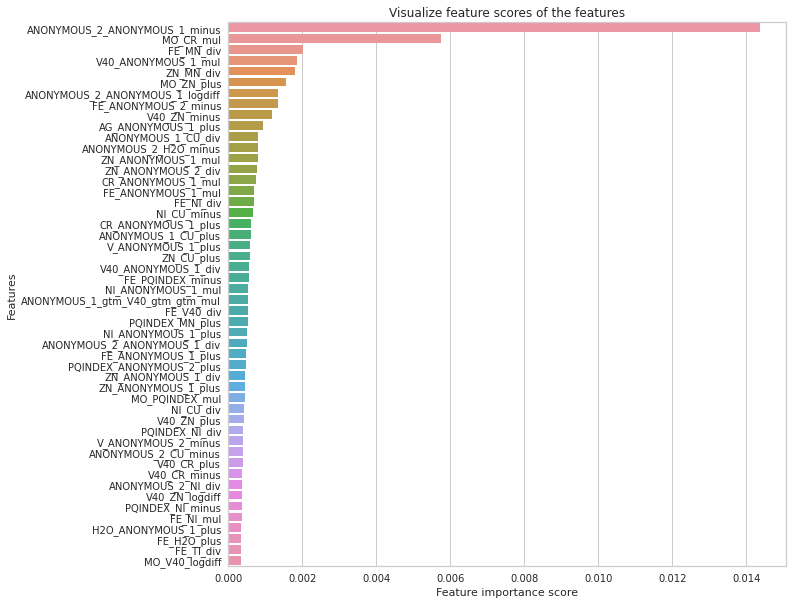

In [17]:
# plot
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x=vi['weight'], y=vi['feature'])
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(vi['feature'])
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

> rf vi

In [18]:
def permutation_rf_vi(train, drop_features):    

    train_df = train.copy()

    # label encoding 
    encoder = LabelEncoder()
    categorical_features = [i for i in train_df.select_dtypes(include=['object','category']).columns.tolist() if i not in ['ID']]
    categorical_features = [i for i in categorical_features if i in train_df.columns.tolist()]
    for each in categorical_features:
        train_df[each] = encoder.fit_transform(train_df[each])

    stratified = True

    if stratified:
        folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1)
    else:
        folds = KFold(n_splits= 5, shuffle=True, random_state=1)

    FEATURES = [f for f in train_df.columns if f not in ['Y_LABEL','ID','SAMPLE_TRANSFER_DAY']+drop_features]
    TARGET_COL = 'Y_LABEL'
    feature_importance_df = pd.DataFrame()
    for fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, train_df[TARGET_COL])): 

        with warnings.catch_warnings():

            warnings.filterwarnings('ignore')
            
            clf = RandomForestClassifier(n_estimators=1000, random_state=1)
            
        # scoring = 'f1'
        perm = PermutationImportance(clf, n_iter=100, scoring='roc_auc',random_state=1).fit(train_df.loc[valid_idx, FEATURES],train_df.loc[valid_idx, TARGET_COL])
        fold_importance_df = eli5.explain_weights_df(perm, top = len(FEATURES), feature_names = FEATURES)
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print(f"Permutation importance for fold {fold}")
    
    return feature_importance_df

In [19]:
%%time 

# CPU times: user 30min 55s, sys: 2.93 s, total: 30min 58s
# Wall time: 8min 45s

drop_features = all_num_features + ['YEAR','COMPONENT_ARBITRARY']

permutation_importance_rf = permutation_rf_vi(train, drop_features)

# save
permutation_importance_rf.to_csv('permutation_importance_rf.csv',index=False)

# check 
permutation_importance_rf.head()

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [20]:
# vi
vi = permutation_importance_rf.groupby(['feature'])['weight'].mean().reset_index()
vi = vi.sort_values(['weight'],ascending=False)
vi = vi.head(50)

NameError: name 'permutation_importance_rf' is not defined

In [ ]:
# plot
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x=vi['weight'], y=vi['feature'])
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(vi['feature'])
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()